In [1]:

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 21:25:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.56.224, 54.231.200.48, 52.216.24.54, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.56.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  23.6MB/s    in 0.5s    

2024-04-07 21:25:14 (23.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Data Downloading and Preparation: First, the notebook downloads and unzips the "Jena climate dataset."

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Data Inspection and Parsing: It reads the header and the number of lines to inspect the dataset. After that, the data is parsed into raw data and temperature values.

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Data Visualisation: The temperature time series is displayed.

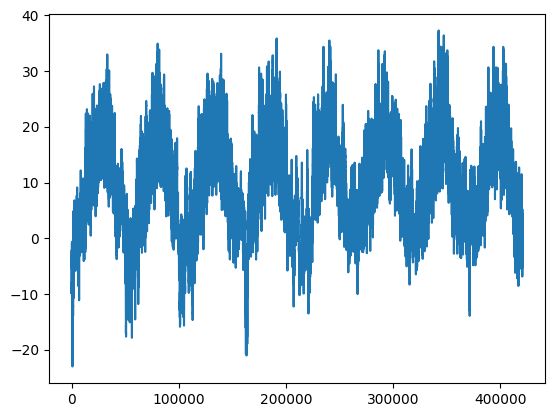

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)


Data Preparation: Training, Validation, and Test Sets are created from the data. By deducting the mean and dividing by the standard deviation, the data are normalised.

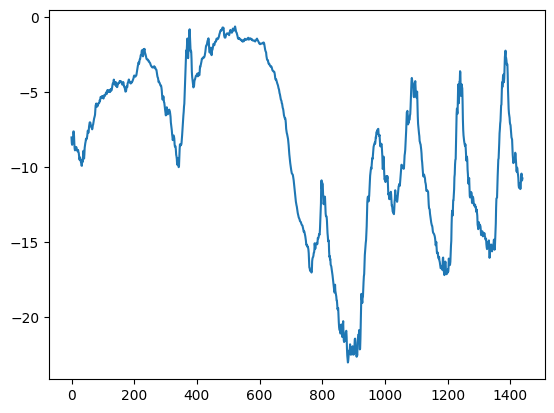

In [5]:
plt.plot(range(1440), temperature[:1440])

Creating Datasets: The TensorFlow timeseries_dataset_from_array function is used to create datasets.

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Baseline Model: It computes a baseline Mean Absolute Error (MAE) using a simple naive approach.

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


Creating Datasets: The TensorFlow timeseries_dataset_from_array function is used to create datasets.

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


1D Convolutional Model: A 1D convolutional neural network model is trained and assessed.

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Models of Recurrent Neural Networks (RNNs): It trains and assesses a range of RNN models, including a basic model based on LSTM.

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 61ms/step - loss: 12.0572 - mae: 2.6841 - val_loss: 9.9675 - val_mae: 2.4918
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 8.6757 - mae: 2.3161 - val_loss: 10.2533 - val_mae: 2.5216
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 8.0868 - mae: 2.2367 - val_loss: 10.1872 - val_mae: 2.5213
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 7.6622 - mae: 2.1796 - val_loss: 10.6972 - val_mae: 2.5851
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 7.3817 - mae: 2.1389 - val_loss: 11.9682 - val_mae: 2.7469
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 7.1584 - mae: 2.1066 - val_loss: 10.8210 - val_mae: 2.6060
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 6.9831 - mae: 2.0818 - val_loss: 11.4653 - val_mae: 2.6848
Epoch 8/10
819/819 [==============================] - 4

RNN comprehension: It offers explanations and code samples, along with an RNN implementation in NumPy and Keras layers.

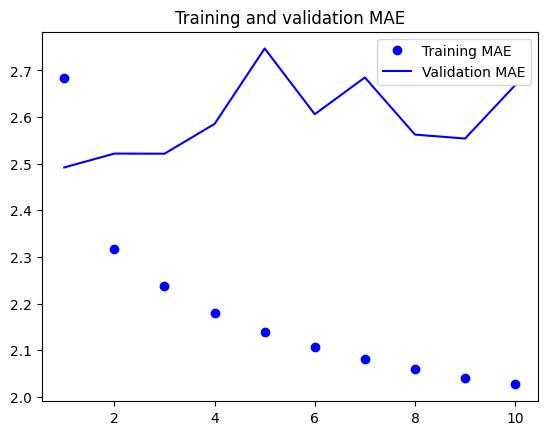

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Advanced RNN Usage: It delves into more complex RNN methods like bidirectional RNNs, stacked RNN layers, and dropout regularisation.

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 116s 138ms/step - loss: 39.9562 - mae: 4.5958 - val_loss: 11.9788 - val_mae: 2.6396
Epoch 2/10
819/819 [==============================] - 91s 111ms/step - loss: 10.9919 - mae: 2.5666 - val_loss: 9.3321 - val_mae: 2.3770
Epoch 3/10
819/819 [==============================] - 113s 137ms/step - loss: 9.7797 - mae: 2.4322 - val_loss: 9.2785 - val_mae: 2.3735
Epoch 4/10
819/819 [==============================] - 92s 112ms/step - loss: 9.2800 - mae: 2.3722 - val_loss: 9.2809 - val_mae: 2.3781
Epoch 5/10
819/819 [==============================] - 112s 136ms/step - loss: 9.0465 - mae: 2.3413 - val_loss: 9.2961 - val_mae: 2.3846
Epoch 6/10
819/819 [==============================] - 111s 136ms/step - loss: 8.8246 - mae: 2.3124 - val_loss: 9.4033 - val_mae: 2.4005
Epoch 7/10
819/819 [==============================] - 92s 112ms/step - loss: 8.6207 - mae: 2.2856 - val_loss: 9.3545 - val_mae: 2.3962
Epoch 8/10
819/819 [============================

In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)


Advanced use of recurrent neural networks
Using recurrent dropout to fight overfitting
Training and evaluating a dropout-regularized LSTM

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/50
819/819 [==============================] - 201s 242ms/step - loss: 27.1077 - mae: 3.8496 - val_loss: 9.5264 - val_mae: 2.3950
Epoch 2/50
819/819 [==============================] - 182s 222ms/step - loss: 14.6928 - mae: 2.9806 - val_loss: 9.1968 - val_mae: 2.3523
Epoch 3/50
819/819 [==============================] - 195s 238ms/step - loss: 13.7641 - mae: 2.8778 - val_loss: 9.4569 - val_mae: 2.3860
Epoch 4/50
819/819 [==============================] - 197s 241ms/step - loss: 13.1162 - mae: 2.8110 - val_loss: 9.1900 - val_mae: 2.3552
Epoch 5/50
819/819 [==============================] - 197s 240ms/step - loss: 12.6595 - mae: 2.7623 - val_loss: 9.3738 - val_mae: 2.3743
Epoch 6/50
819/819 [==============================] - 182s 221ms/step - loss: 12.2702 - mae: 2.7195 - val_loss: 9.2237 - val_mae: 2.3569
Epoch 7/50
819/819 [==============================] - 181s 221ms/step - loss: 11.9307 - mae: 2.6861 - val_loss: 9.2845 - val_mae: 2.3608
Epoch 8/50
819/819 [=====================

In [22]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 319s 376ms/step - loss: 24.9305 - mae: 3.6921 - val_loss: 9.5983 - val_mae: 2.3977
Epoch 2/50
819/819 [==============================] - 306s 373ms/step - loss: 13.9984 - mae: 2.8971 - val_loss: 9.3122 - val_mae: 2.3725
Epoch 3/50
819/819 [==============================] - 299s 365ms/step - loss: 13.1369 - mae: 2.8071 - val_loss: 8.9947 - val_mae: 2.3190
Epoch 4/50
819/819 [==============================] - 325s 396ms/step - loss: 12.5602 - mae: 2.7474 - val_loss: 8.7998 - val_mae: 2.2953
Epoch 5/50
819/819 [==============================] - 316s 386ms/step - loss: 12.0884 - mae: 2.6965 - val_loss: 8.9928 - val_mae: 2.3243
Epoch 6/50
819/819 [==============================] - 305s 372ms/step - loss: 11.6980 - mae: 2.6536 - val_loss: 8.5860 - val_mae: 2.2640
Epoch 7/50
819/819 [==============================] - 304s 371ms/step - loss: 11.2997 - mae: 2.6084 - val_loss: 8.9626 - val_mae: 2.3139
Epoch 8/50
819/819 [=====================

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)


Epoch 1/10
819/819 [==============================] - 151s 180ms/step - loss: 27.2248 - mae: 3.7371 - val_loss: 10.9651 - val_mae: 2.5776
Epoch 2/10
819/819 [==============================] - 130s 159ms/step - loss: 9.5168 - mae: 2.4111 - val_loss: 10.1701 - val_mae: 2.4729
Epoch 3/10
819/819 [==============================] - 143s 174ms/step - loss: 8.6455 - mae: 2.2858 - val_loss: 10.1383 - val_mae: 2.4668
Epoch 4/10
819/819 [==============================] - 128s 156ms/step - loss: 8.1175 - mae: 2.2111 - val_loss: 9.9867 - val_mae: 2.4480
Epoch 5/10
819/819 [==============================] - 128s 156ms/step - loss: 7.6316 - mae: 2.1447 - val_loss: 10.3615 - val_mae: 2.4845
Epoch 6/10
819/819 [==============================] - 128s 156ms/step - loss: 7.2852 - mae: 2.0949 - val_loss: 10.4773 - val_mae: 2.5026
Epoch 7/10
819/819 [==============================] - 142s 173ms/step - loss: 7.0258 - mae: 2.0569 - val_loss: 10.5074 - val_mae: 2.4977
Epoch 8/10
819/819 [=====================